In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import joblib
import matplotlib.pyplot as plt

In [ ]:
root = '/content/drive/MyDrive/Bitcoin/'

In [ ]:
# Load OOS train predictions
arima_train = np.load(f"{root}predictions/arima_train_preds.npy")
xgb_train = np.load(f"{root}predictions/xgb_train_preds.npy")
lstm_train = np.load(f"{root}predictions/lstm_train_preds.npy")

# Load test predictions
arima_test = np.load(f"{root}predictions/arima_test_preds.npy")
xgb_test = np.load(f"{root}predictions/xgb_test_preds.npy")
lstm_test = np.load(f"{root}predictions/lstm_test_preds.npy")

# Load actual targets
y_train = np.load(f"{root}preprocessed/y_train_lstm.npy")
y_test = np.load(f"{root}preprocessed/y_test_lstm.npy")

In [ ]:
# LSTM is shortest, so trim others to match
lstm_length = len(lstm_train)

arima_train_trim = arima_train[:lstm_length]
xgb_train_trim   = xgb_train[:lstm_length]
lstm_train_trim  = lstm_train[:lstm_length]
y_train_trim     = y_train[:lstm_length]

In [ ]:
valid = ~(np.isnan(arima_train_trim) | np.isnan(xgb_train_trim) | np.isnan(lstm_train_trim))

arima_train_clean = arima_train_trim[valid]
xgb_train_clean   = xgb_train_trim[valid]
lstm_train_clean  = lstm_train_trim[valid]
y_train_clean     = y_train_trim[valid]

In [ ]:
X_train_meta = np.column_stack([arima_train_clean, xgb_train_clean, lstm_train_clean])
X_test_meta = np.column_stack([arima_test, xgb_test, lstm_test])

In [ ]:
meta_model = Ridge(alpha=10.0)
meta_model.fit(X_train_meta, y_train_clean)

Ridge(alpha=10.0)

In [ ]:
meta_preds_test = meta_model.predict(X_test_meta)

# Show learned weights
weights = meta_model.coef_
print(f"\nLearned Weights:")
print(f"  ARIMA:   {weights[0]:.4f}")
print(f"  XGBoost: {weights[1]:.4f}")
print(f"  LSTM:    {weights[2]:.4f}")
print(f"  Intercept: {meta_model.intercept_:.4f}")


Learned Weights:
  ARIMA:   -0.3084
  XGBoost: -0.0379
  LSTM:    0.4717
  Intercept: 0.0762


In [ ]:
def directional_accuracy(actual, pred):
    return np.mean(np.sign(actual) == np.sign(pred)) * 100

dir_acc = directional_accuracy(y_test, meta_preds_test)
correlation = np.corrcoef(meta_preds_test, y_test)[0, 1]
r2 = r2_score(y_test, meta_preds_test)
strategy_returns = np.sign(meta_preds_test) * y_test
sharpe = strategy_returns.mean() / (strategy_returns.std() + 1e-8)

print("\n=== Meta-Model Performance ===")
print(f"Directional Accuracy: {dir_acc:.2f}%")
print(f"Correlation:          {correlation:.4f}")
print(f"R²:                   {r2:.4f}")
print(f"Sharpe Ratio:         {sharpe:.4f}")


=== Meta-Model Performance ===
Directional Accuracy: 53.51%
Correlation:          -0.0185
R²:                   -0.0050
Sharpe Ratio:         0.0639


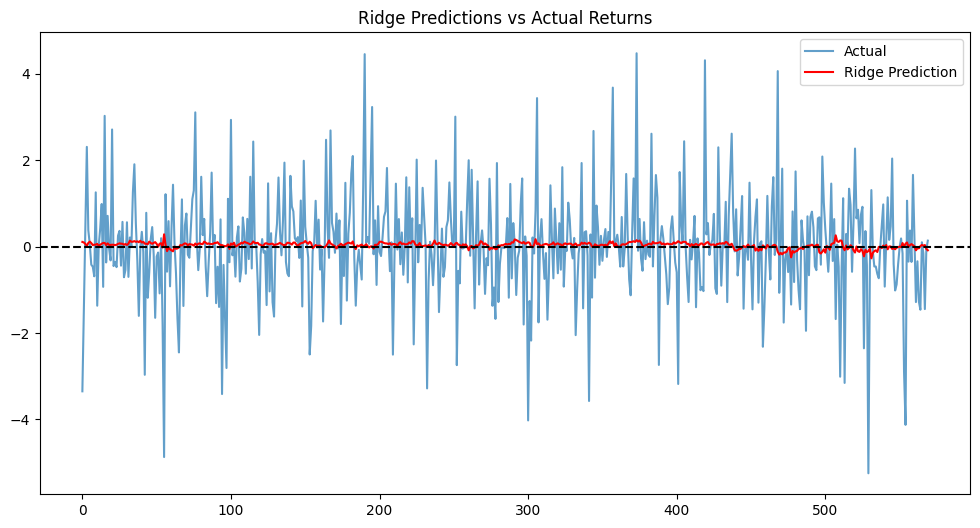

In [16]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual", alpha=0.7)
plt.plot(meta_preds_test, label="Ridge Prediction", color="red")
plt.axhline(0, color="black", linestyle="--")
plt.title("Ridge Predictions vs Actual Returns")
plt.legend()
plt.show()

In [ ]:
print("\n" + "="*60)
print("Comparison: Meta-Model vs Base Models")
print("="*60)

base_model_scores = {
    'ARIMA': directional_accuracy(y_test, arima_test),
    'XGBoost': directional_accuracy(y_test, xgb_test),
    'LSTM': directional_accuracy(y_test, lstm_test)
}

print("\nBase Models:")
for name, score in base_model_scores.items():
    print(f"  {name:12s}: {score:.2f}%")

print(f"\nMeta-Model (Ridge): {dir_acc:.2f}%")

best_base = max(base_model_scores.values())
improvement = dir_acc - best_base

if improvement > 0:
    print(f"\n✅ Improvement: +{improvement:.2f}% over best base model")
else:
    print(f"\n⚠️  No improvement: {improvement:.2f}% vs best base model")


Comparison: Meta-Model vs Base Models

Base Models:
  ARIMA       : 50.00%
  XGBoost     : 52.46%
  LSTM        : 52.63%

Meta-Model (Ridge): 53.51%

✅ Improvement: +0.88% over best base model


In [ ]:
# Save meta-model
joblib.dump(meta_model, f"{root}models/meta_model_ridge.pkl")

# Save predictions
np.save(f"{root}predictions/meta_ridge_test_preds.npy", meta_preds_test)

# Save results summary for report
results_summary = {
    'meta_model': 'Ridge',
    'alpha': 1.0,
    'weights': {
        'ARIMA': weights[0],
        'XGBoost': weights[1],
        'LSTM': weights[2]
    },
    'intercept': meta_model.intercept_,
    'test_metrics': {
        'directional_accuracy': dir_acc,
        'correlation': correlation,
        'r2': r2,
        'sharpe': sharpe
    },
    'base_model_scores': base_model_scores,
    'improvement': improvement
}
joblib.dump(results_summary, f"{root}models/meta_model_results.pkl")

print("\n" + "="*60)
print("Meta-Model Training Complete!")
print("="*60)
print(f"\nSaved:")
print(f"  - Model: {root}models/meta_model_ridge.pkl")
print(f"  - Predictions: {root}predictions/meta_ridge_test_preds.npy")
print(f"  - Results: {root}models/meta_model_results.pkl")


Meta-Model Training Complete!

Saved:
  - Model: /content/drive/MyDrive/Bitcoin/models/meta_model_ridge.pkl
  - Predictions: /content/drive/MyDrive/Bitcoin/predictions/meta_ridge_test_preds.npy
  - Results: /content/drive/MyDrive/Bitcoin/models/meta_model_results.pkl
